## Demo Notebook to show potential quicklooks

In [47]:
import sys
sys.path.insert(1, '..')
import warnings
import os
from importlib import reload
import xarray as xr
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

from functions import thermo as th
from functions import plotting as pf
reload(th)
reload(pf)

import metpy
import metpy.calc as mpcalc
from metpy.units import units

from pylab import shape,size
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
import glob

import cartopy as cp
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import LAND
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates

from pandas import DataFrame
from sklearn import linear_model

# CAUTION: suppressing warnings here is only to keep this tutorial clean; not recommended for regular use
warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
warnings.filterwarnings('ignore', 'This function will be removed in tqdm==5.0.0')
warnings.filterwarnings('ignore', 'Mean of empty slice')
warnings.filterwarnings('ignore', 'Degrees of freedom <= 0 for slice')

In [69]:
import configparser

config = configparser.ConfigParser()
config.read('run_config.cfg')

# set in and out dir
in_dir = config['DEFAULT']['directory']

if config.getboolean('output_directory','same_as_input') == True:
    out_dir = in_dir
else:
    out_dir = config['output_directory']['output_directory']
    
if os.path.isdir(os.path.join(out_dir, 'Plots')) == False:
    os.mkdir(os.path.join(out_dir, 'Plots'))

In [29]:
allfiles = sorted(glob.glob(in_dir + config['DEFAULT']['aspen_suffix']))     # remember to add level folder

ori_list = [None] * len(allfiles)
new_index = {'alt':np.arange(0,9100,10)}

g = 0
for i in allfiles :
    ori_list[g] = xr.open_dataset(i).dropna(dim='time',subset=['time']).isel(obs=0).\
                  swap_dims({'time':'alt'}).reset_coords().\
                  dropna(dim='alt',subset=['alt','pres','u_wind','v_wind','lat','lon','mr'],
                         how='any').\
                  interp(alt=np.arange(0,9100,10))
    g = g + 1

ds = xr.concat(ori_list[:],dim='launch_time')

ds['T'] = ds['tdry'] + 273.15

ds['q'] = (['launch_time','alt'],
            metpy.calc.specific_humidity_from_mixing_ratio(ds['mr']).data)

In [30]:
## Integrated Water Vapour

iwv = [None] * len(ds['launch_time'])
    
for i in range(len(ds['launch_time'])) :

    iwv[i] = metpy.calc.precipitable_water(ds['pres'].isel(launch_time=i).values*units.mbar,
                                           ds['dp'].isel(launch_time=i).values*units.degC,).magnitude

ds['iwv'] = (['launch_time'],iwv)

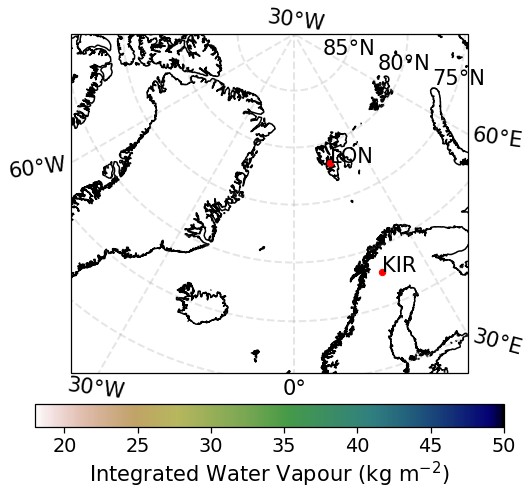

In [56]:
# Plotting a spatial variability of IWV

sb.set_context('notebook',font_scale=1.75)
fig = plt.figure(figsize = (12,8))

ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.coastlines(resolution='10m',linewidth=1.5);

arr = ds['iwv']

for i in range(len(ds['launch_time'])) :
    im = ax.scatter(ds['lon'].isel(alt=-400), ds['lat'].isel(alt=-400),
                marker='o',s=90,transform=ccrs.PlateCarree(),c=iwv,cmap='gist_earth_r',vmin=18,vmax=50)

for k in np.arange(len(config.get('quicklooks', 'landmark_labels').split(', '))):
    landm_lat = float(config.get('quicklooks', 'landmark_lats').split(', ')[k])
    landm_lon = float(config.get('quicklooks', 'landmark_lons').split(', ')[k])
    landm_label = config.get('quicklooks', 'landmark_labels').split(', ')[k]
    
    ax.text(landm_lon+0.05, landm_lat+0.05, landm_label, c='k', transform=ccrs.PlateCarree())
    ax.scatter(landm_lon, landm_lat, marker='o', s=40, c='r', transform=ccrs.PlateCarree())

# Assigning axes ticks
xticks = np.arange(-180,180,1.5); yticks = np.arange(-90,90,1.5)

# set extent
area = [int(item) for item in config.get('quicklooks', 'area').split(', ')]
ax.set_extent(area, crs=ccrs.PlateCarree())

# Setting up the gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--')

g = plt.colorbar(im, orientation='horizontal',shrink=0.7,pad=.07)
g.set_label('Integrated Water Vapour (kg m$^{-2}$)')
plt.tick_params(labelsize=15)

plt.savefig(os.path.join(out_dir, 'Plots/quicklook_iwv_positions.png' ))

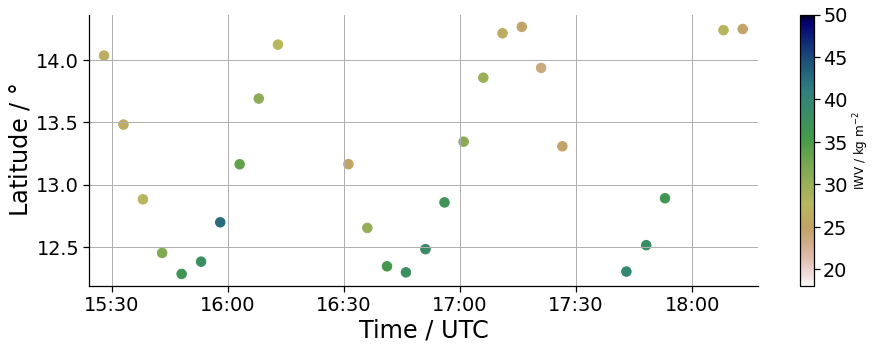

In [57]:
ax = plt.figure(figsize=(15,5))

plt.scatter(ds['launch_time'].values,ds['lat'].isel(alt=-400).values,s=90,
            c=ds['iwv'],vmin=18,vmax=50,cmap='gist_earth_r')

plt.xlim(np.min(ds['launch_time'].values) - np.timedelta64(4, 'm'),
        np.max(ds['launch_time'].values) + np.timedelta64(4, 'm'))

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.grid()

g = plt.colorbar()
g.set_label('IWV / kg m$^{-2}$',fontsize=12)

myFmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.xlabel('Time / UTC',fontsize=24)
plt.ylabel('Latitude / $\degree$',fontsize=24)

plt.savefig(os.path.join(out_dir, 'Plots/quicklook_iwv_timeseries.png'))

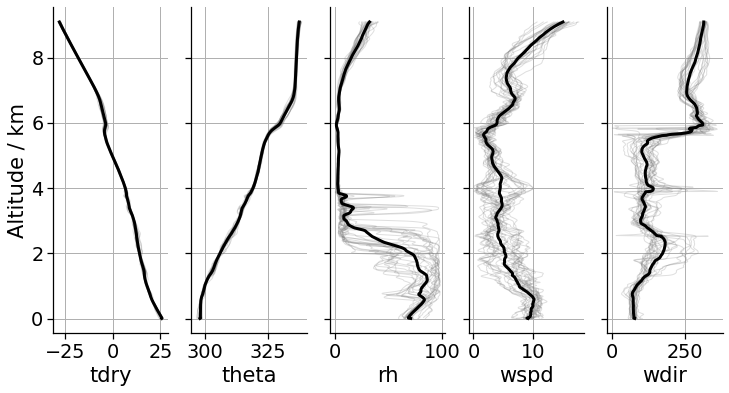

In [73]:
row = 1; col = len(config.get('quicklooks', 'vertical_profiles').split(', '))

f,ax = plt.subplots(row,col,sharey=True,figsize=(12,6))

r = config.get('quicklooks', 'vertical_profiles').split(', ')

for j in range(col) :
    d = ds[r[j]]
    for i in range(1,len(ds['launch_time'])-1) :
        ax[j].plot(d.isel(launch_time=i),
                ds['alt']/1000,
                   c='grey',alpha=0.25,linewidth=1)
        
    ax[j].plot(np.nanmean(d,axis=0),
               ds['alt']/1000,
                          linewidth=3,c='k')
    
    ax[j].set_xlabel(r[j])
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['top'].set_visible(False)
    ax[j].grid()
    
    if j == 0 :
        ax[j].set_ylabel('Altitude / km')
        
plt.savefig(os.path.join(out_dir, 'Plots/quicklook_vertical_profiles.png'))

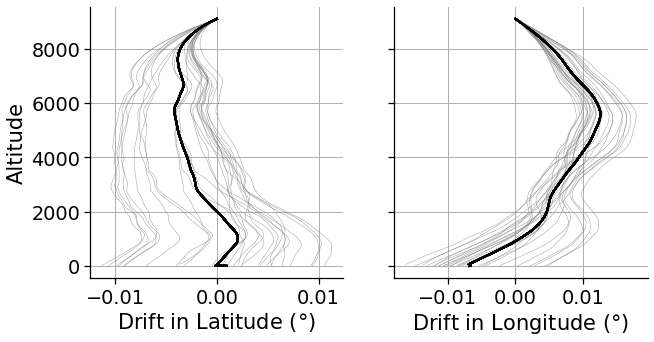

In [77]:
f,ax = plt.subplots(1,2,sharey=True,figsize=(10,5))

for i in range(len(ds['launch_time'])) :
    
    ax[0].plot(ds['lat'].isel(launch_time=i) - ds['lat'].isel(launch_time=i).isel(alt=-1),
             ds['alt'],linewidth=0.5,c='grey',alpha=0.75)
    ax[0].plot(np.mean(ds['lat'] - ds['lat'].isel(alt=-1),axis=0),
             ds['alt'],linewidth=2,c='k',alpha=1)
    ax[0].set_xlabel('Drift in Latitude ($\degree$)')
    ax[0].set_ylabel('Altitude')
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].grid()
    
    ax[1].plot(ds['lon'].isel(launch_time=i) - ds['lon'].isel(launch_time=i).isel(alt=-1),
             ds['alt'],linewidth=0.5,c='grey',alpha=0.75)
    ax[1].plot(np.mean(ds['lon'] - ds['lon'].isel(alt=-1),axis=0),
             ds['alt'],linewidth=2,c='k',alpha=1)
    ax[1].set_xlabel('Drift in Longitude ($\degree$)')
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['left'].set_visible(True)
    ax[1].grid()

plt.savefig(os.path.join(out_dir, 'Plots/quicklook_drift.png'))

In [78]:
mse = th.calc_mse(ds['T'],ds['mr']/1000,ds['alt'])
mse_mean = np.nanmean(mse,axis=0)
mse_std = np.nanstd(mse,axis=0)

dse = th.calc_dse(ds['T'],ds['mr']/1000,ds['alt'])
dse_mean = np.nanmean(dse,axis=0)
dse_std = np.nanstd(dse,axis=0)

smse = th.calc_mse(ds['T'],th.q_sat(ds['T'],ds['pres']*100),ds['alt'])
smse_mean = np.nanmean(smse,axis=0)
smse_std = np.nanstd(smse,axis=0)

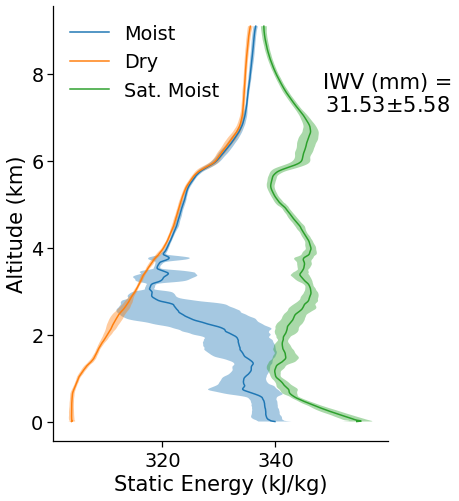

In [80]:
f = plt.figure(figsize=(6,8))

plt.plot(mse_mean/1000,ds['alt']/1000,label='Moist')
plt.fill_betweenx(ds['alt']/1000,
                 (mse_mean - mse_std)/1000,
                 (mse_mean + mse_std)/1000,
                 alpha=0.4)

plt.plot(dse_mean/1000,ds['alt']/1000,label='Dry')
plt.fill_betweenx(ds['alt']/1000,
                 (dse_mean - dse_std)/1000,
                 (dse_mean + dse_std)/1000,
                 alpha=0.4)

plt.plot(smse_mean/1000,ds['alt']/1000,label='Sat. Moist')
plt.fill_betweenx(ds['alt']/1000,
                 (smse_mean - smse_std)/1000,
                 (smse_mean + smse_std)/1000,
                 alpha=0.4)

plt.legend(frameon=False,loc=2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.text(1,0.8,'IWV (mm) =\n' 
         + str(round(np.nanmean(iwv),2)) + '$\pm$'
         + str(round(np.std(iwv),2)), 
         horizontalalignment='center',
        verticalalignment='center', transform=plt.gca().transAxes)
plt.xlabel('Static Energy (kJ/kg)')
plt.ylabel('Altitude (km)')

plt.savefig(os.path.join(out_dir, 'Plots/quicklook_static_energy.png'))

# More ideas / opinions / wishes for Quicklooks? 
# Maybe some synergy quicklooks?